In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 50)

In [2]:
nba_1984_2018_initials = {
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BRK',
    'Charlotte Hornets': 'CHH',
    'Charlotte Bobcats': 'CHO',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Kansas City Kings': 'KCK',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Hornets' : 'NOP',
    'New Orleans/Oklahoma City Hornets': 'NOK',
    'New Orleans Pelicans': 'NOP',
    'New Jersey Nets': 'NJN',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHO',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Diego Clippers': 'SDC',
    'San Antonio Spurs': 'SAS',
    'Seattle SuperSonics': 'SEA',
    'Toronto Raptors': 'TOR',
    'Vancouver Grizzlies': 'VAN',
    'Utah Jazz': 'UTA',
    'Washington Bullets': 'WSB',
    'Washington Wizards': 'WAS'
}
nba_1984_2018_initials_reversed = {v:k for k, v in nba_1984_2018_initials.items()}

In [3]:
boxscore_season_range_mask = lambda df, start_year, end_year:  (df["season"] >= start_year) & (df["season"] <= end_year)
boxscore_date_range_mask = lambda df, start_date, end_date: (df["date"] >= start_date) & (df["date"] <= end_date)
boxscore_team_mask = lambda df, team_initials: (df["team1"] == team_initials) | (df["team2"] == team_initials)
boxscore_regular_season_mask = lambda df: pd.isnull(df["playoff"])

summary_season_range = lambda df, start_year, end_year: df.loc[start_year:end_year]
summary_season_query = lambda df, years, teams, col_names: df.loc[(years, teams), col_names]
summary_season_remove_league_average = lambda: df

In [4]:
def wins_for_regular_season(abbrev, season, df_boxscore):
    '''
    determine the number of wins a team had during specified regular season
    
    abbrev: string, 3 letter initial of NBA team
    season: int, year (2017 refers to 2016-17 NBA regular season)
    df_boxscore: pd.DataFrame, see nba_boxscores_1984_2018.csv for format
    
    returns tuple (wins, winning_percentage)
    '''
    season_mask = boxscore_season_range_mask(df_boxscore, season, season)
    regular_season_mask = boxscore_regular_season_mask(df_boxscore)
    team_mask = boxscore_team_mask(df_boxscore, abbrev)
    df_team_slice = df_boxscore[(season_mask) & (regular_season_mask) & (team_mask)]
    w = 0
    gp = 0
    for _, g in df_team_slice.iterrows():
        if g["team1"] == abbrev:
            # team is home, check for home team win
            if g["result"] == 1:
                w += 1
        else:
            # team is away, check for home team loss
            if g["result"] == 0:
                w += 1
        gp += 1
    return (w, w/gp)

def wins_for_playoffs(abbrev, season, df_boxscore):
    '''
    determine the number of wins a team had during playoffs of given season
    
    abbrev: string, 3 letter initial of NBA team
    season: int, year (2017 refers to 2016-17 NBA regular season)
    df_boxscore: pd.DataFrame, see nba_boxscores_1984_2018.csv for format
    
    returns tuple (postseason_wins, postseason_winning_percentage) if team made playoffs, else None
    '''
    season_mask = boxscore_season_range_mask(df_boxscore, season, season)
    playoff_mask = ~boxscore_regular_season_mask(df_boxscore)
    team_mask = boxscore_team_mask(df_boxscore, abbrev)
    df_team_slice = df_boxscore[(season_mask) & (playoff_mask) & (team_mask)]
    if df_team_slice.shape[0] == 0:
        # team didn't make playoffs this season
        return None
    w = 0
    gp = 0
    for _, g in df_team_slice.iterrows():
        if g["team1"] == abbrev:
            # team is home, check for home team win
            if g["result"] == 1:
                w += 1
        else:
            # team is away, check for home team loss
            if g["result"] == 0:
                w += 1
        gp += 1
    return (w, w/gp)

def predicted_wins_for_regular_season(abbrev, season, df_predictions, predict_col):
    '''
    determine the predicted number of wins a team had during the specified regular season
    
    abbrev: string, 3 letter initials of NBA team
    season: int, year (2017 refers to 2016-17 NBA regular season)
    df_predictions: pd.DataFrame, see nba_boxscores_predictions_1985_2017.csv for format
    predict_col: string, name of column with home team win probabilities
    
    returns tuple (predicted_wins, predicted_winning_percentage)
    '''
    season_mask = boxscore_season_range_mask(df_predictions, season, season)
    regular_season_mask = boxscore_regular_season_mask(df_predictions)
    team_mask = boxscore_team_mask(df_predictions, abbrev)
    df_team_slice = df_predictions[(season_mask) & (regular_season_mask) & (team_mask)]
    pred = []
    gp = 0
    for _, g in df_team_slice.iterrows():
        if g["team1"] == abbrev:
            # team is home, check home team win probability
            pred.append(g[predict_col])
        else:
            # team is away, win probability = 1 - home team win probability
            pred.append(1 - g[predict_col])
        gp += 1
    pred_win_percentage = sum(pred) / len(pred)
    return (pred_win_percentage * gp, pred_win_percentage)

def predicted_wins_for_playoffs(abbrev, season, df_predictions, predict_col):
    '''
    determine the predicted number of wins for a team during playoffs of given season
    
    abbrev: string, 3 letter initials of NBA team
    season: int, year (2017 refers to 2016-17 NBA regular season)
    df_predictions: pd.DataFrame, see nba_boxscores_predictions_1985_2017.csv for format
    predict_col: string, prediction column name in df_predictions (1 = home win, 0 = home loss)
    
    returns tuple (playoff_predicted_wins, playoff_predicted_winning_percentage) if team made playoffs, else None
    '''
    season_mask = boxscore_season_range_mask(df_predictions, season, season)
    playoff_mask = ~(boxscore_regular_season_mask(df_predictions))
    team_mask = boxscore_team_mask(df_predictions, abbrev)
    df_team_slice = df_predictions[(season_mask) & (playoff_mask) & (team_mask)]
    if df_team_slice.shape[0] == 0:
        # team didn't make playoffs this season
        return None
    pred = []
    gp = 0
    for _, g in df_team_slice.iterrows():
        if g["team1"] == abbrev:
            # team is home, check for home team win
            pred.append(g[predict_col])
        else:
            # team is away, check for home team loss
            pred.append(1 - g[predict_col])
        gp += 1
    pred_win_percentage = sum(pred) / len(pred)
    return (pred_win_percentage * gp, pred_win_percentage)

def rmse(predictions, actuals):
    '''
    determine the root mean square error
    
    predictions: nd.ndarray, predicted values
    actuals: nd.ndarray, actual values (must be same dimension as predictions)
    '''
    return np.sqrt(((predictions - actuals) ** 2).mean())

# Evaluate best training models on test data

** Test seasons: [2016, 1988, 1995, 2002, 2008, 2010, 2013] **

In [5]:
# predictions dataframe has weighted and unweighted clf predictions and prediction probabilities for all NBA games from 1985 to 2017
df_predictions = pd.read_csv("../Data/nba_boxscores_predictions_1985_2017.csv", index_col=0, parse_dates=[1], infer_datetime_format=True)
df_predictions.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,carmelo1_pre,carmelo2_pre,carmelo1_post,carmelo2_post,carmelo_prob1,carmelo_prob2,score1,score2,team2_Pace,team2_eFG%,team2_TOV%,team2_ORB%,team2_FT/FGA,team2_ORtg,team2_DRtg,team2_NetRtg,team1_Pace,team1_eFG%,team1_TOV%,team1_ORB%,team1_FT/FGA,team1_ORtg,team1_DRtg,team1_NetRtg,elo_pred,result,weighted_clf_pred,weighted_clf_pred_prob,unweighted_clf_pred,unweighted_clf_pred_prob
25815,1984-10-26,1985,0,NaN,CHI,WSB,1377.2302,1455.0490,0.531878,0.468122,1390.1630,1442.1162,NaN,NaN,NaN,NaN,NaN,NaN,109.0,93.0,106.0,0.408,19.7,34.0,0.196,87.8,102.9,-15.1,106.0,0.551,19.4,28.2,0.136,102.9,87.8,15.1,1,1,1,0.527428,1,0.532164
25816,1984-10-26,1985,0,NaN,SEA,UTA,1501.9596,1492.9644,0.651906,0.348094,1507.7736,1487.1504,NaN,NaN,NaN,NaN,NaN,NaN,102.0,94.0,106.0,0.368,20.4,20.5,0.500,88.7,96.3,-7.6,106.0,0.414,19.7,43.6,0.345,96.3,88.7,7.6,1,1,1,0.642616,1,0.634148
25817,1984-10-26,1985,0,NaN,PHI,CLE,1555.1931,1406.9590,0.806738,0.193262,1558.5397,1403.6124,NaN,NaN,NaN,NaN,NaN,NaN,111.0,101.0,96.5,0.438,14.3,37.5,0.258,104.6,115.0,-10.4,96.5,0.483,11.2,40.0,0.281,115.0,104.6,10.4,1,1,1,0.806241,1,0.807776
25818,1984-10-26,1985,0,NaN,DET,BOS,1574.7426,1643.8761,0.544304,0.455696,1565.3525,1653.2661,NaN,NaN,NaN,NaN,NaN,NaN,123.0,130.0,108.0,0.535,11.1,35.6,0.230,120.4,113.9,6.5,108.0,0.450,6.8,31.7,0.207,113.9,120.4,-6.5,1,0,1,0.535855,1,0.535196
25819,1984-10-26,1985,0,NaN,NJN,ATL,1562.4678,1507.9084,0.708831,0.291169,1540.6881,1529.6881,NaN,NaN,NaN,NaN,NaN,NaN,104.0,119.0,103.5,0.585,17.8,34.3,0.182,114.9,100.5,14.4,103.5,0.466,15.9,28.6,0.264,100.5,114.9,-14.4,1,0,1,0.705551,1,0.707228


In [6]:
# weighted_X_test, unweighted_X_test, weighted_y_test, and unweighted_y_test all have identical indices. 
test_indices = joblib.load("../Data/weighted_X_test.pkl").index
test_seasons = list(set(df_predictions.loc[test_indices]["season"]))
print(test_seasons)

[2016, 1988, 1995, 2002, 2008, 2010, 2013]


In [9]:
d_regular_seasons = {s: {} for s in test_seasons}
for s in d_regular_seasons.keys():
    season_mask = boxscore_season_range_mask(df_predictions, s, s)
    regular_season_mask = boxscore_regular_season_mask(df_predictions)
    prediction_df_for_season = df_predictions[(season_mask) & (regular_season_mask)]
    teams_for_season = list(set(list(prediction_df_for_season["team1"]) + list(prediction_df_for_season["team2"])))
    team_d = {}
    for t in teams_for_season:
        actual_wins, actual_win_percentage = wins_for_regular_season(t, s, df_predictions)
        predicted_wins_elo, predicted_win_percentage_elo = predicted_wins_for_regular_season(t, s, df_predictions, "elo_prob1")
        predicted_wins_weighted, predicted_win_percentage_weighted = predicted_wins_for_regular_season(t, s, df_predictions, "weighted_clf_pred_prob")
        predicted_wins_unweighted, predicted_win_percentage_unweighted = predicted_wins_for_regular_season(t, s, df_predictions, "unweighted_clf_pred_prob")
        team_d[t] = {
            'actual_wins': actual_wins,
            'actual_win_percentage': actual_win_percentage,
            'predicted_wins_elo': predicted_wins_elo,
            'predicted_win_percentage_elo': predicted_win_percentage_elo,
            'predicted_wins_weighted': predicted_wins_weighted,
            'predicted_win_percentage_weighted': predicted_win_percentage_weighted,
            'predicted_wins_unweighted': predicted_wins_unweighted,
            'predicted_win_percentage_unweighted': predicted_win_percentage_unweighted
        }
    d_regular_seasons[s] = team_d

In [10]:
d_regular_seasons[2016]["GSW"]

{'actual_win_percentage': 0.8902439024390244,
 'actual_wins': 73,
 'predicted_win_percentage_elo': 0.8160250454913646,
 'predicted_win_percentage_unweighted': 0.8152664152267729,
 'predicted_win_percentage_weighted': 0.8187053240511101,
 'predicted_wins_elo': 66.9140537302919,
 'predicted_wins_unweighted': 66.85184604859538,
 'predicted_wins_weighted': 67.13383657219103}

In [11]:
d_playoffs = {s: {} for s in test_seasons}
for s in d_playoffs.keys():
    season_mask = boxscore_season_range_mask(df_predictions, s, s)
    playoffs_mask = ~(boxscore_regular_season_mask(df_predictions))
    prediction_df_for_season = df_predictions[(season_mask) & (playoffs_mask)]
    teams_for_playoffs = list(set(list(prediction_df_for_season["team1"]) + list(prediction_df_for_season["team2"])))
    team_d = {}
    for t in teams_for_playoffs:
        actual_wins, actual_win_percentage = wins_for_playoffs(t, s, df_predictions)
        predicted_wins_elo, predicted_win_percentage_elo = predicted_wins_for_playoffs(t, s, df_predictions, "elo_prob1")
        predicted_wins_weighted, predicted_win_percentage_weighted = predicted_wins_for_playoffs(t, s, df_predictions, "weighted_clf_pred_prob")
        predicted_wins_unweighted, predicted_win_percentage_unweighted = predicted_wins_for_playoffs(t, s, df_predictions, "unweighted_clf_pred_prob")
        team_d[t] = {
            'actual_wins': actual_wins,
            'actual_win_percentage': actual_win_percentage,
            'predicted_wins_elo': predicted_wins_elo,
            'predicted_win_percentage_elo': predicted_win_percentage_elo,
            'predicted_wins_weighted': predicted_wins_weighted,
            'predicted_win_percentage_weighted': predicted_win_percentage_weighted,
            'predicted_wins_unweighted': predicted_wins_unweighted,
            'predicted_win_percentage_unweighted': predicted_win_percentage_unweighted
        }
    d_playoffs[s] = team_d

In [12]:
d_playoffs[2016]["CLE"]

{'actual_win_percentage': 0.7619047619047619,
 'actual_wins': 16,
 'predicted_win_percentage_elo': 0.5510920489208977,
 'predicted_win_percentage_unweighted': 0.5481295581966568,
 'predicted_win_percentage_weighted': 0.5531451776273164,
 'predicted_wins_elo': 11.572933027338852,
 'predicted_wins_unweighted': 11.510720722129792,
 'predicted_wins_weighted': 11.616048730173645}

In [13]:
d_2016 = d_regular_seasons[2016]
dp_2016 = d_playoffs[2016]

<IPython.core.display.Javascript object>


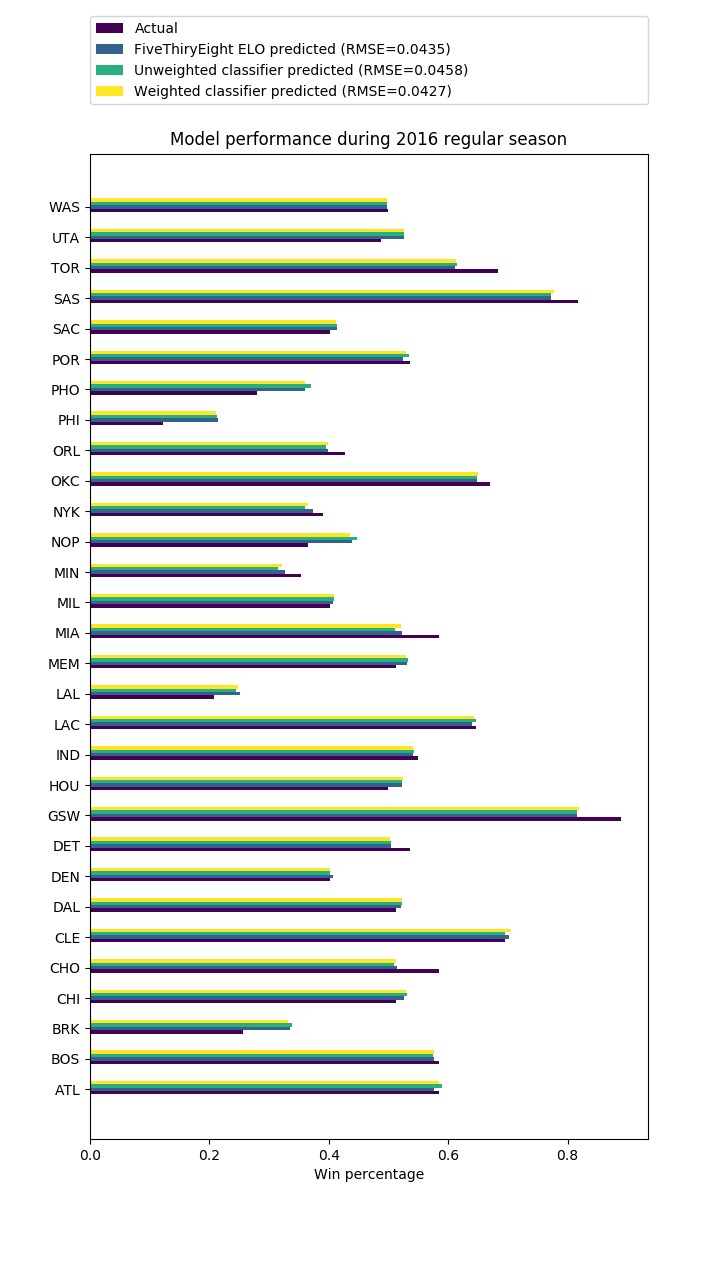

In [14]:
sorted_team_names = sorted(d_2016.keys())
actual_win_percentages, predicted_win_percentages_elo, predicted_win_percentages_unweighted, predicted_win_percentages_weighted = zip(*[(d_2016[k]["actual_win_percentage"], d_2016[k]["predicted_win_percentage_elo"], d_2016[k]["predicted_win_percentage_unweighted"], d_2016[k]["predicted_win_percentage_weighted"])  for k in sorted_team_names])
elo_rmse = rmse(np.array(predicted_win_percentages_elo), np.array(actual_win_percentages))
unweighted_rmse = rmse(np.array(predicted_win_percentages_unweighted), np.array(actual_win_percentages))
weighted_rmse = rmse(np.array(predicted_win_percentages_weighted), np.array(actual_win_percentages))

fig = plt.figure(1, figsize=(7.2, 12.8), dpi=100)
ax = plt.subplot(111)
ax.set_title("Model performance during 2016 regular season")
N = len(sorted_team_names)
ind = np.arange(N*9)
actual_win_percentage_ind = ind[::9]
predicted_elo_win_percentage_ind = ind[1::9]
predicted_unweighted_win_percentage_ind = ind[2::9]
predicted_weighted_win_percentage_ind = ind[3::9]

width = 1.0
ax.barh(actual_win_percentage_ind, actual_win_percentages, height=width, label='Actual', color="#440154FF")
ax.barh(predicted_elo_win_percentage_ind, predicted_win_percentages_elo, height=width, label='FiveThiryEight ELO predicted (RMSE={})'.format(round(elo_rmse, 4)), color="#33638DFF")
ax.barh(predicted_unweighted_win_percentage_ind, predicted_win_percentages_unweighted, height=width, label='Unweighted classifier predicted (RMSE={})'.format(round(unweighted_rmse, 4)), color="#29AF7FFF")
ax.barh(predicted_weighted_win_percentage_ind, predicted_win_percentages_weighted, height=width, label='Weighted classifier predicted (RMSE={})'.format(round(weighted_rmse, 4)), color="#FDE725FF")
ax.set_xlabel("Win percentage")
ax.set_yticks(predicted_elo_win_percentage_ind)
ax.set_yticklabels(sorted_team_names)
ax.legend(bbox_to_anchor=(0., 1.05, 1., .105), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

<IPython.core.display.Javascript object>


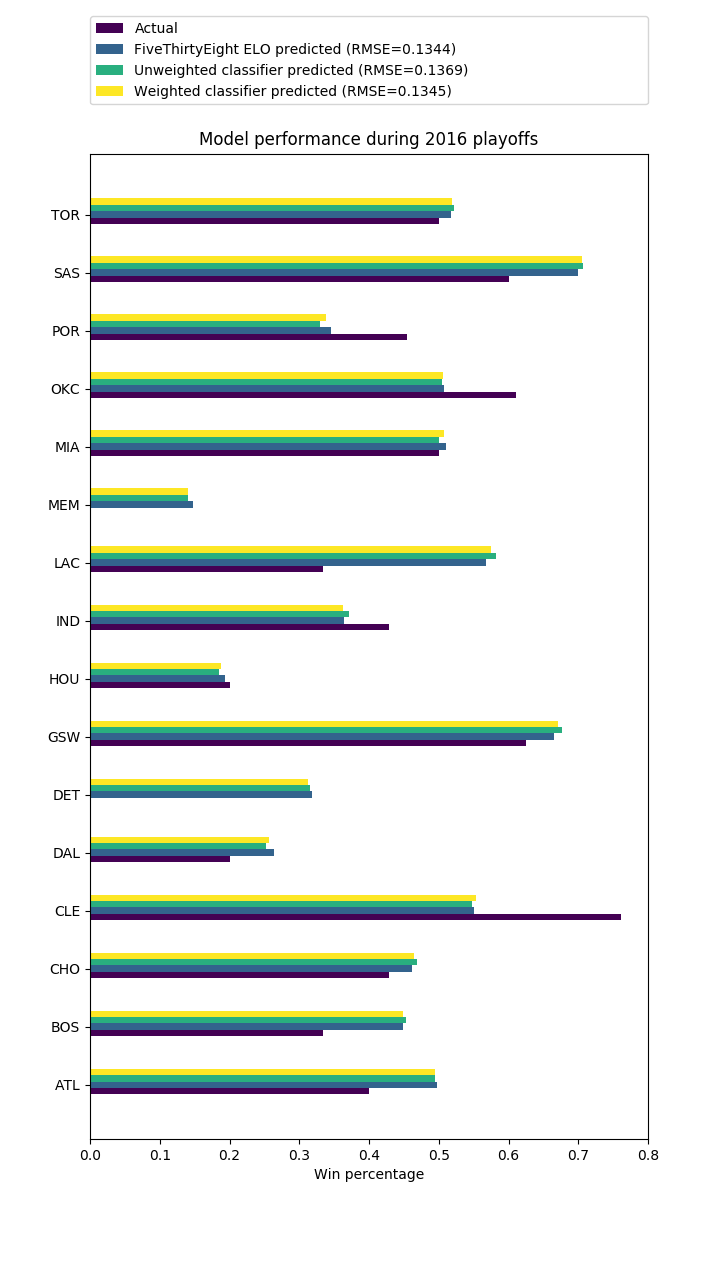

In [15]:
sorted_team_names = sorted(dp_2016.keys())
actual_win_percentages, predicted_win_percentages_elo, predicted_win_percentages_unweighted, predicted_win_percentages_weighted = zip(*[(dp_2016[k]["actual_win_percentage"], dp_2016[k]["predicted_win_percentage_elo"], dp_2016[k]["predicted_win_percentage_unweighted"], dp_2016[k]["predicted_win_percentage_weighted"])  for k in sorted_team_names])
elo_rmse = rmse(np.array(predicted_win_percentages_elo), np.array(actual_win_percentages))
unweighted_rmse = rmse(np.array(predicted_win_percentages_unweighted), np.array(actual_win_percentages))
weighted_rmse = rmse(np.array(predicted_win_percentages_weighted), np.array(actual_win_percentages))

fig = plt.figure(2, figsize=(7.2, 12.8), dpi=100)
ax = plt.subplot(111)
ax.set_title("Model performance during 2016 playoffs")
N = len(sorted_team_names)
ind = np.arange(N*9)
actual_win_percentage_ind = ind[::9]
predicted_elo_win_percentage_ind = ind[1::9]
predicted_unweighted_win_percentage_ind = ind[2::9]
predicted_weighted_win_percentage_ind = ind[3::9]

width = 1.0
ax.barh(actual_win_percentage_ind, actual_win_percentages, height=width, label='Actual', color="#440154FF")
ax.barh(predicted_elo_win_percentage_ind, predicted_win_percentages_elo, height=width, label='FiveThirtyEight ELO predicted (RMSE={})'.format(round(elo_rmse, 4)), color="#33638DFF")
ax.barh(predicted_unweighted_win_percentage_ind, predicted_win_percentages_unweighted, height=width, label='Unweighted classifier predicted (RMSE={})'.format(round(unweighted_rmse, 4)), color="#29AF7FFF")
ax.barh(predicted_weighted_win_percentage_ind, predicted_win_percentages_weighted, height=width, label='Weighted classifier predicted (RMSE={})'.format(round(weighted_rmse, 4)), color="#FDE725FF")
ax.set_xlabel("Win percentage")
ax.set_yticks(predicted_elo_win_percentage_ind)
ax.set_yticklabels(sorted_team_names)
ax.legend(bbox_to_anchor=(0., 1.05, 1., .105), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

In [16]:
elo_rmses = {}
unweighted_rmses = {}
weighted_rmses = {}

ps_elo_rmses = {}
ps_unweighted_rmses = {}
ps_weighted_rmses = {}

In [27]:
for season in d_regular_seasons.keys():
    actual_win_percentages, predicted_win_percentages_elo, predicted_win_percentages_unweighted, predicted_win_percentages_weighted = zip(*[(d_regular_seasons[season][t]["actual_win_percentage"], d_regular_seasons[season][t]["predicted_win_percentage_elo"], d_regular_seasons[season][t]["predicted_win_percentage_unweighted"], d_regular_seasons[season][t]["predicted_win_percentage_weighted"])  for t in d_regular_seasons[season].keys()])
    elo_rmses[season] = rmse(np.array(predicted_win_percentages_elo), np.array(actual_win_percentages))
    unweighted_rmses[season] = rmse(np.array(predicted_win_percentages_unweighted), np.array(actual_win_percentages))
    weighted_rmses[season] = rmse(np.array(predicted_win_percentages_weighted), np.array(actual_win_percentages))
rs_elo_rmse, rs_elo_std = np.mean(list(elo_rmses.values())), np.std(list(elo_rmses.values()))
rs_unweighted_rmse, rs_unweighted_std = np.mean(list(unweighted_rmses.values())), np.std(list(unweighted_rmses.values()))
rs_weighted_rmse, rs_weighted_std = np.mean(list(weighted_rmses.values())), np.std(list(weighted_rmses.values()))

for season in d_playoffs.keys():
    actual_win_percentages, predicted_win_percentages_elo, predicted_win_percentages_unweighted, predicted_win_percentages_weighted = zip(*[(d_playoffs[season][t]["actual_win_percentage"], d_playoffs[season][t]["predicted_win_percentage_elo"], d_playoffs[season][t]["predicted_win_percentage_unweighted"], d_playoffs[season][t]["predicted_win_percentage_weighted"])  for t in d_playoffs[season].keys()])
    ps_elo_rmses[season] = rmse(np.array(predicted_win_percentages_elo), np.array(actual_win_percentages))
    ps_unweighted_rmses[season] = rmse(np.array(predicted_win_percentages_unweighted), np.array(actual_win_percentages))
    ps_weighted_rmses[season] = rmse(np.array(predicted_win_percentages_weighted), np.array(actual_win_percentages))
ps_elo_rmse, ps_elo_std = np.mean(list(ps_elo_rmses.values())), np.std(list(ps_elo_rmses.values()))
ps_unweighted_rmse, ps_unweighted_std = np.mean(list(ps_unweighted_rmses.values())), np.std(list(ps_unweighted_rmses.values()))
ps_weighted_rmse, ps_weighted_std = np.mean(list(ps_weighted_rmses.values())), np.std(list(ps_weighted_rmses.values()))

<IPython.core.display.Javascript object>


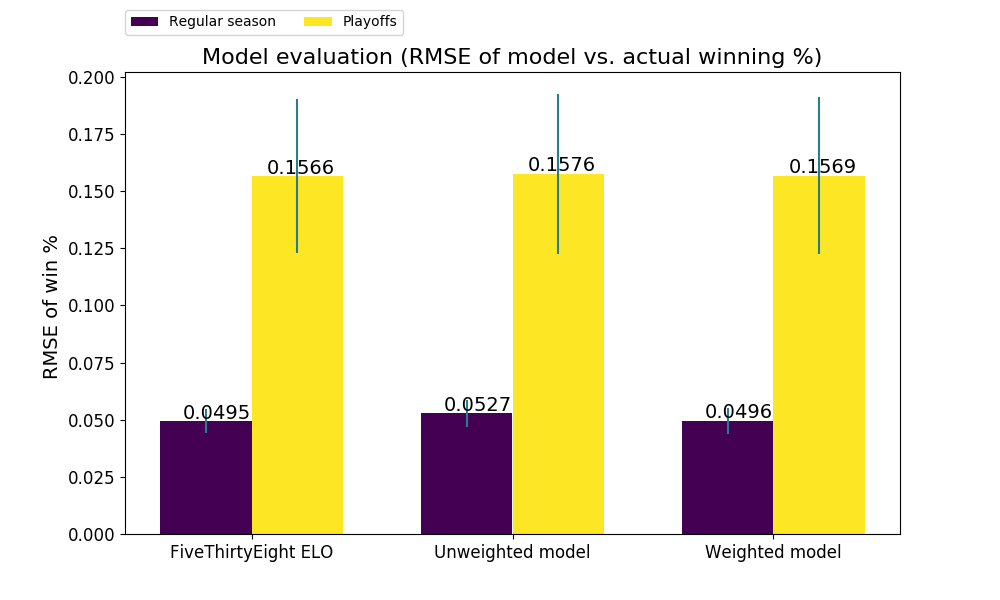

In [38]:
rs_rmses = [rs_elo_rmse, rs_unweighted_rmse, rs_weighted_rmse]
rs_stds = [rs_elo_std, rs_unweighted_std, rs_weighted_std] 
ps_rmses = (ps_elo_rmse, ps_unweighted_rmse, ps_weighted_rmse)
ps_stds = [ps_elo_std, ps_unweighted_std, ps_weighted_std]

ind = np.arange(len(rs_rmses)) 
width = 0.35
plt.figure(3, figsize=(10, 6), dpi=100)
b1 = plt.bar(ind, rs_rmses, width, label='Regular season', color="#440154FF", yerr=rs_stds, ecolor="#287D8EFF")
b2 = plt.bar(ind + width, ps_rmses, width, label='Playoffs', color="#FDE725FF", yerr=ps_stds, ecolor="#287D8EFF")

plt.ylabel('RMSE of win % ', size=14)
plt.title('Model evaluation (RMSE of model vs. actual winning %)', size=16)

plt.yticks(size=12)
plt.xticks(ind + width / 2, ('FiveThirtyEight ELO', 'Unweighted model', 'Weighted model'), size=12)
plt.legend(bbox_to_anchor=(0., 1.08, 1., .108), loc=3,
           ncol=2, borderaxespad=0.)
for i in range(len(ind)): 
    plt.text(ind[i] - (width/4), rs_rmses[i] + .001, str(round(rs_rmses[i], 4)), size=14)
    plt.text(ind[i] + (width/1.5), ps_rmses[i] + .001, str(round(ps_rmses[i], 4)), size=14)